In [1]:
import pandas as pd
import numpy as np
from dist_analysis.distance import DistanceSim, kendall_tau

**Cambridge Data Cleaning**

In [2]:
cambridge = pd.read_csv("data/Cambridge city council 2009.csv")
cambridge = cambridge[['rank1', 'rank2', 'rank3']]
parts = []
for rank in cambridge.columns:
    parts.append(cambridge[rank].value_counts().reset_index())

agg = parts[0].merge(parts[1], on='index')
agg = agg.merge(parts[2], on='index')

clean_agg = agg[~agg['index'].isin(['overvote', 'skipped', 'Write-In 2', 'Write-In 3'])]
clean_agg

,index,rank1,rank2,rank3
0,"Davis, Henrietta",1847,1745,1410
1,"Simmons, E. Denise",1776,1719,1499
2,"Toomey, Jr., Timothy J.",1737,1093,968
3,"Decker, Marjorie C.",1284,599,370
4,"Maher, David P.",1283,1111,921
5,"Kelley, Craig A.",1245,887,797
6,"Reeves, Kenneth E.",1157,1214,983
7,"Seidel, Sam",899,1152,1145
8,"Sullivan, Edward J.",877,955,659
9,"Cheung, Leland",755,662,651


**IRV Ranking for Cambridge**

In [3]:
import random
import itertools
from numpy.random import choice
import random

# Helper functions for rcv_sim
def remove_cand(cand, ballot_list):
    for n, ballot in enumerate(ballot_list):
        new_ballot = []
        for c in ballot:
            if c!= cand:
                new_ballot.append(c)
        ballot_list[n]= new_ballot

def recompute_count(candidates, ballot_list):
    cand_totals = {}
    for cand in candidates:
        cand_totals[cand] = len([ballot for ballot in ballot_list if ballot[0] == cand])
    return cand_totals

# Transfer method functions
def cincinnati_transfer(cand, ballot_list, win_lose, cutoff):
    if win_lose == 'lose':
        remove_cand(cand, ballot_list)
    else:
        cand_ballots_index = []
        single_cand_ballots_index = []
        for n, ballot in enumerate(ballot_list):
            if ballot[0] == cand and len(ballot) == 1:
                single_cand_ballots_index.append(n)
            elif ballot[0] == cand and len(ballot) >1:
                cand_ballots_index.append(n)

        rand_winners1 = random.sample(single_cand_ballots_index, min(int(cutoff), len(single_cand_ballots_index)))
        rand_winners2 = random.sample(cand_ballots_index, int(cutoff)- len(rand_winners1))
        rand_winners = rand_winners1 + rand_winners2

        #remove winning ballots from simulation
        for index in sorted(rand_winners, reverse = True):
            del ballot_list[index]

        #remove candidate from rest of ballots
        remove_cand(cand, ballot_list)


def rcv_run(ballot_list, cand_list, num_seats, transfer_method, verbose_bool=False):
    winners = []
    losers = []
    cutoff = int(len(ballot_list)/(num_seats+1) + 1)
    candidates = cand_list.copy()
    ballot_list = [x for x in ballot_list if x != []]
    cand_totals = recompute_count(candidates, ballot_list)

    while len(winners) < num_seats:
        remaining_cands = candidates
        if len(remaining_cands) == num_seats - len(winners):
            winners = winners + remaining_cands
            # remove remaining candidates from list of candidates
            candidates = []
            break

        cand_totals = recompute_count(candidates, ballot_list)

        for cand in list(candidates):
            if len(winners) == num_seats:
                    break
            if cand_totals[cand] >= cutoff:
                winners.append(cand)
                transfer_method(cand, ballot_list, "win", cutoff)
                candidates.remove(cand)
                ballot_list = [x for x in ballot_list if x != []]
                cand_totals = recompute_count(candidates, ballot_list)
                if verbose_bool:
                    print("candidate", cand, "elected")

        if len(winners) == num_seats:
            break

        min_count = min(cand_totals.values())
        min_cand_list = [k for k,v in cand_totals.items() if v == min_count]
        min_cand = random.choice(min_cand_list)
        losers.append(min_cand)
     #   min_cand = min(cand_totals, key=cand_totals.get)
        transfer_method(min_cand, ballot_list, "lose", cutoff)
        candidates.remove(min_cand)
        ballot_list = [x for x in ballot_list if x != []]
        cand_totals= recompute_count(candidates, ballot_list)
        if verbose_bool:
            print("candidate", min_cand, "eliminated")

    # sort remaining candidates by vote totals
    candidates = sorted(candidates, key = lambda x: cand_totals[x])
    canidates = list(reversed(candidates))


    # edge case where last remaining candidate is actually the winner
    if winners == candidates:
        candidates = []
    # print("winners, losers, leftovers:")
    # print(winners, losers, candidates)

    candidate_ranking = winners + candidates + list(reversed(losers))
    return candidate_ranking

In [4]:
cam_ballots = cambridge.values.tolist()
cam_cand_list = cambridge['rank3'].unique()
num_seats = 1

camb_irv = rcv_run(cam_ballots, list(cam_cand_list), num_seats, cincinnati_transfer)
to_remove = ['overvote', 'skipped', 'Write-In 2', 'Write-In 3', 'Write-In 4','Write-In 9']
for cand in camb_irv:
    if cand  in to_remove:
        camb_irv.remove(cand)

cam_irv = camb_irv[0:-2]
cam_id = dict([(c, int(v)) for c, v in zip(clean_agg['index'], range(1, len(clean_agg)+1))])
clean_agg['IRV order'] = list(map(lambda k: cam_id[k], cam_irv))
clean_agg = clean_agg.rename(columns={'index' : 'candidate', 'rank1' : 'first', 'rank2' : 'second', 'rank3' : 'third'})
clean_agg

/var/folders/9c/588vmzx576d47gqhpgtw95v00000gn/T/ipykernel_47878/443791121.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_agg['IRV order'] = list(map(lambda k: cam_id[k], cam_irv))


,candidate,first,second,third,IRV order
0,"Davis, Henrietta",1847,1745,1410,1
1,"Simmons, E. Denise",1776,1719,1499,2
2,"Toomey, Jr., Timothy J.",1737,1093,968,3
3,"Decker, Marjorie C.",1284,599,370,5
4,"Maher, David P.",1283,1111,921,6
5,"Kelley, Craig A.",1245,887,797,7
6,"Reeves, Kenneth E.",1157,1214,983,4
7,"Seidel, Sam",899,1152,1145,8
8,"Sullivan, Edward J.",877,955,659,10
9,"Cheung, Leland",755,662,651,9


/Users/jackgibson/Documents/mggg_summer23/rcv-distances/dist_analysis/distance.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


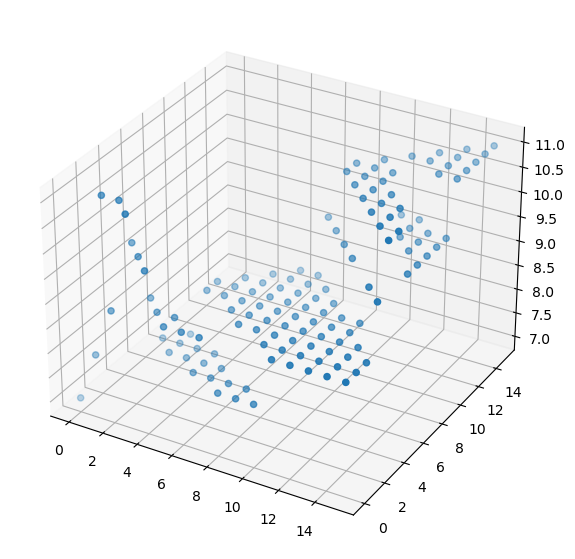

In [8]:
cam_model = DistanceSim(clean_agg, kendall_tau)

m = 15
cam_model.calc_distances(15)
cam_model.gen_3d_plot()

In [9]:
min_sets = cam_model.find_min_sets()
min_sets

,a,b,c,dist
135,15.0,0.0,0.0,7.0
